# Cell cycle kinetics

In [14]:
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
exec(open('settings.py').read(), globals())

In [15]:
switchpoint = -800
TC6dlist = pd.read_csv('../data/TC6d.csv', squeeze = True)

In [16]:
cell_number_data = pd.read_csv('../data/cell_number_data.csv')
cell_number_data = cell_number_data.query('pos >= @switchpoint')[['ID', 'time', 'm', 'PCNA']].dropna()
cell_number_data['mi_rel'] = cell_number_data['m'] / cell_number_data['PCNA']
mi_data = cell_number_data[['ID', 'time', 'mi_rel']]
animal_mean = mi_data.groupby('ID').agg(['mean', 'sem'])
time = animal_mean['time', 'mean']
mean_mi_data = mi_data.groupby('ID').mean().groupby('time').agg(['mean','sem'])
mean_mi_data.columns = mean_mi_data.columns.droplevel()
mean_mi_data = mean_mi_data

In [17]:
TC6d = TC6dlist.mean()
TC6d_sigma = TC6dlist.std()

TCdata = pd.DataFrame(columns = ['mean','sigma'], index = pd.Index(cell_number_data['time'].unique(), name = 'time'))
TCdata.loc[6] = [TC6d, TC6d_sigma]

mi6d = mean_mi_data.loc[6, 'mean']
mi6d_sigma = mean_mi_data.loc[6, 'sem']

for time in [0, 3, 4, 8]:
    mi = mean_mi_data.loc[time, 'mean']
    mi_sigma = mean_mi_data.loc[time, 'sem']
    TCdata.loc[time, 'mean'] = mi6d / mi * TC6d
    TCdata.loc[time, 'sigma'] = TCdata.loc[time, 'mean'] * (TC6d_sigma / TC6d + mi6d_sigma / mi6d + mi_sigma / mi)
TCdata = TCdata.reset_index()    

In [18]:
animal_mean['TC', ''] = TC6d * mi6d / animal_mean['mi_rel', 'mean']
animal_mean['TCsigma', ''] = animal_mean['TC', ''] * (TC6d_sigma / TC6d + animal_mean['mi_rel', 'sem'] / animal_mean['mi_rel', 'mean'] + mi6d_sigma / mi6d)

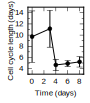

In [19]:
fig, ax = plt.subplots(figsize = (1, 1.2))
fig.patch.set_alpha(1.0)
ax.errorbar(TCdata['time'], TCdata['mean'], TCdata['sigma'], ls = '-',  marker = 'o', color ='black')
ax.set_xlim(-0.7, 8.7)
ax.set_ylim(3, 15)
ax.set_yticks(sp.arange(3, 15, 2), minor=True)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Cell cycle length (days)')
ax.tick_params(axis='both', which='major')
plt.savefig('../figure_plots/supplement_Fig2G_cell_cycle_length_dynamics.svg')
plt.show()

Showing individual animals

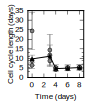

In [20]:
fig, ax = plt.subplots(figsize = (1, 1.2))
fig.patch.set_alpha(1.0)
ax.errorbar(animal_mean['time', 'mean'], animal_mean['TC'], animal_mean['TCsigma'], ls = '',  marker = 'o', color ='grey')
ax.plot(TCdata['time'], TCdata['mean'], ls = '-',  marker = '^', color ='black')
ax.set_xlim(-0.7, 8.7)
# ax.set_ylim(3, 15)
ax.set_yticks(sp.arange(3, 15, 2), minor=True)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Cell cycle length (days)')
ax.tick_params(axis='both', which='major')
# plt.savefig('../figure_plots/Fig2_cell_cycle_length_kinetics.svg')
plt.show()

In [21]:
TCdata

,time,mean,sigma
0,0,9.72447,4.60853
1,3,11.1431,3.31234
2,4,4.65262,1.00317
3,6,4.90251,0.535331
4,8,5.21026,0.933248


## Significance of differences in proliferation rate

t-test between timepoint 0 and other groups performed on the relative mitotic index (that's the mitotic index scaled by the mean AP cell length):

In [22]:
mi0 = sp.array(animal_mean[animal_mean['time', 'mean'] == 0]['mi_rel', 'mean'])
for t in sp.delete(animal_mean['time', 'mean'].unique(), 0):
    mit = sp.array(animal_mean[animal_mean['time', 'mean'] == t]['mi_rel', 'mean'])
    pt = sp.stats.ttest_ind(mi0, mit).pvalue
    print t, pt

3 0.733854259286
4 0.0365488236621
6 0.0422386957577
8 0.0580503923787


## Plot of the proliferation rate dynamics

In [23]:
prol_rate = pd.DataFrame()
prol_rate['time'] = TCdata['time']
prol_rate['mean'] = sp.log(2) / TCdata['mean']
prol_rate['sigma'] = prol_rate['mean'] * TCdata['sigma'] / TCdata['mean']
prol_rate

,time,mean,sigma
0,0,0.0712786,0.0337797
1,3,0.0622041,0.0184904
2,4,0.14898,0.0321222
3,6,0.141386,0.0154387
4,8,0.133035,0.0238288


In [24]:
from matplotlib.markers import TICKDOWN

def significance_bar(start,end,height,displaystring,linewidth = 1,markersize = 3,boxpad  =0.3,fontsize = 12,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',size = fontsize)

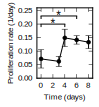

In [18]:
fig, ax = plt.subplots(figsize = (1, 31.5/25.0))
fig.patch.set_alpha(1.0)
ax.errorbar(prol_rate['time'], prol_rate['mean'], prol_rate['sigma'], ls = '-',  marker = 'o', color ='black')
ax.set_xlim(-0.7, 8.7)
ax.set_ylim(0, 0.26)
#ax.set_yticks(sp.arange(3, 15, 2), minor=True)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Proliferation rate (1/day)', labelpad=10)

significance_bar(0, 6, 0.23, '*')
significance_bar(0, 4, 0.2, '*')

#ax.tick_params(axis='both', which='major')
plt.savefig('../figure_plots/Fig2_proliferation_rate_dynamics.svg')
plt.show()